# Velocity gradient time series - 4:1 Axisymmetric contraction

Flow: steady-state Newtonian at Re=1.

When streamlines are computed by ParaView, one column of the interpolated data is `"IntegrationTime"` which is used to rephrase the data as Lagrangian particles (instead of streamlines).

In [1]:
import numpy as np
from scipy.interpolate import interp1d
import pywt

from ipywidgets import interactive, fixed
import ipywidgets as widgets

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]

folder = 'inputs/contraction'

files = [
    'tracer_y0.0005.csv',
    'tracer_y0.0010.csv',
    'tracer_y0.0015.csv',
    'tracer_y0.0020.csv',
    'tracer_y0.0025.csv',
    'tracer_y0.0030.csv',
    'tracer_y0.0035.csv'
]

output_file = 'inputs/contraction/scenario_contraction'

## Import velocity gradient data

In [2]:
times = []
gradUs = []
# Pre-normalizing factor (this is properly done later)
f = 10

for file in files:
    data = np.loadtxt(f'{folder}/{file}', delimiter=',', usecols=list(range(4,14)), skiprows=1) 
    times.append(data[:,-1]*f)
    gradUs.append(data[:,:-1].reshape((len(data), 3, 3))/f)

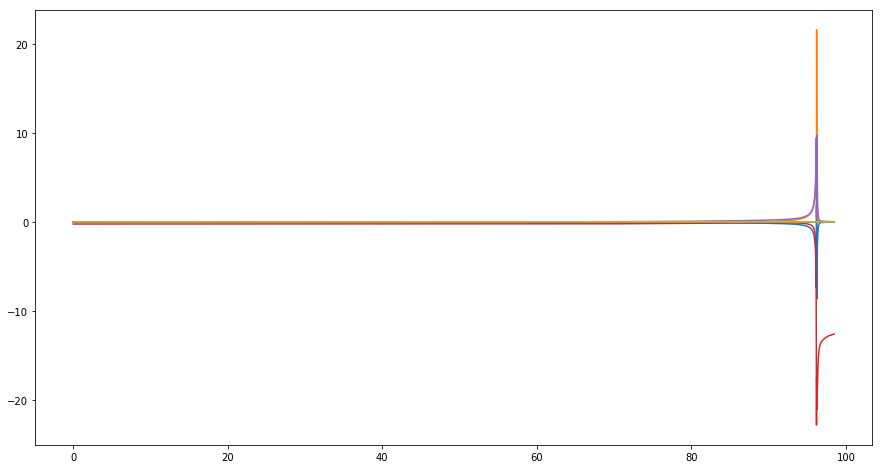

Max trace: 1.7797679733485299


In [3]:
plt.plot(times[-1], gradUs[-1].reshape(len(times[-1]),9))
plt.show()
print(f"Max trace: {np.max(gradUs[0][:,0,0]+gradUs[0][:,1,1]+gradUs[0][:,2,2])}")

In [5]:
def zoom(tb, trajectory, line):
    figure, ax = plt.subplots(nrows=2)
    ax[0].plot(gradUs[trajectory][:,line,0], c='#1d91c0', linewidth=2, label='ix')
    ax[0].plot(gradUs[trajectory][:,line,1], c='#7fcdbb', linewidth=2, label='iy')
    ax[0].plot(gradUs[trajectory][:,line,2], c='#c7e9b4', linewidth=2, label='iz')
    ax[0].legend()
    

    ax[1].plot(gradUs[trajectory][tb[0]:tb[1],line,0], c='#1d91c0', linewidth=2, label='ix')
    ax[1].plot(gradUs[trajectory][tb[0]:tb[1],line,1], c='#7fcdbb', linewidth=2, label='iy')
    ax[1].plot(gradUs[trajectory][tb[0]:tb[1],line,2], c='#c7e9b4', linewidth=2, label='iz')
    
    ax[1].set_title('Zoom')
    ax[0].axvline(tb[0], c='r')
    ax[0].axvline(tb[1], c='r')
    
    plt.show()


w = interactive(zoom, tb=widgets.IntRangeSlider(
                    value=[0, len(gradUs[0])-1],
                    description='Index range:',
                    min=0,
                    max=len(gradUs[0])-1, 
                    continuous_update=False
                    ),
                     trajectory=widgets.Dropdown(
                    options=list(range(len(gradUs))),
                    value=0,
                    description='Trajectory #:',
                    disabled=False,
                    ),
                    line=widgets.Dropdown(
                    options=[('xx, xy, xz', 0),('yx, yy, yz', 1),('zx, zy, zz', 2)],
                    value=0,
                    description='Line:',
                    disabled=False,
                    )
                
               )
w

interactive(children=(IntRangeSlider(value=(0, 609), continuous_update=False, description='Index range:', max=…

## Remove trace

In [6]:
print(f"Max trace: {np.max(gradUs[0][:,0,0]+gradUs[0][:,1,1]+gradUs[0][:,2,2])}")

for i, gradU in enumerate(gradUs):
    # Here we don't trust the value zz
    trgU = gradU[:,0,0] + gradU[:,1,1] + gradU[:,2,2]
    gradUs[i][:,2,2] = - gradU[:,0,0] - gradU[:,1,1]
    
print(f"Max trace: {np.max(gradUs[0][:,0,0]+gradUs[0][:,1,1]+gradUs[0][:,2,2])}")

Max trace: 1.7797679733485299
Max trace: 0.0


## Analyse strain

In [7]:
gradUs_norm = []
times_norm = []

for gradU, time in zip(gradUs, times):

    # Get principal values for the strain
    D = 0.5*(gradU + np.transpose(gradU, axes=(0,2,1)))
    strains = np.linalg.eigvalsh(D)
    max_Wi = np.max(strains[:,2])
    
    # Normalize
    gradUs_norm.append(gradU/max_Wi)
    times_norm.append(time*max_Wi)
    print(f"Maximum strain rate: {max_Wi}")
    print(f"Normalised length of trajecotry: {time[-1]*max_Wi}")

Maximum strain rate: 3.568382189112658
Normalised length of trajecotry: 121.49917538132325
Maximum strain rate: 3.786845297002905
Normalised length of trajecotry: 133.6101253779705
Maximum strain rate: 4.22869345997719
Normalised length of trajecotry: 142.6403046563351
Maximum strain rate: 5.0797560255308305
Normalised length of trajecotry: 171.6384842777222
Maximum strain rate: 6.502325536691279
Normalised length of trajecotry: 248.0689485710519
Maximum strain rate: 8.316612745885585
Normalised length of trajecotry: 427.3029460908507
Maximum strain rate: 10.87151323062176
Normalised length of trajecotry: 1070.718585217399


## Crop

In [8]:
def crop(tb, trajectory):
    figure, ax = plt.subplots(nrows=2)
    ax[0].plot(times_norm[trajectory], gradUs_norm[trajectory][:,0,0], c='#1d91c0', linewidth=2, label='xx')
    ax[0].plot(times_norm[trajectory], gradUs_norm[trajectory][:,0,1], c='#7fcdbb', linewidth=2, label='xy')
    ax[0].plot(times_norm[trajectory], gradUs_norm[trajectory][:,0,2], c='#c7e9b4', linewidth=2, label='xz')
    ax[0].plot(times_norm[trajectory], gradUs_norm[trajectory][:,1,0], c='#0c2c84', linewidth=2, label='yx')
    ax[0].legend()
    

    ax[1].plot(times_norm[trajectory][tb[0]:tb[1]], gradUs_norm[trajectory][tb[0]:tb[1],0,0], c='#1d91c0', linewidth=2, label='xx')
    ax[1].plot(times_norm[trajectory][tb[0]:tb[1]], gradUs_norm[trajectory][tb[0]:tb[1],0,1], c='#7fcdbb', linewidth=2, label='xy')
    ax[1].plot(times_norm[trajectory][tb[0]:tb[1]], gradUs_norm[trajectory][tb[0]:tb[1],0,2], c='#c7e9b4', linewidth=2, label='xz')
    ax[1].plot(times_norm[trajectory][tb[0]:tb[1]], gradUs_norm[trajectory][tb[0]:tb[1],1,0], c='#0c2c84', linewidth=2, label='yx')
    
    ax[1].set_title('Zoom')
    ax[0].axvline(times_norm[trajectory][tb[0]], c='r')
    ax[0].axvline(times_norm[trajectory][tb[1]], c='r')
    
    plt.show()

#tab_contents
sliders = [widgets.IntRangeSlider(
                    value=[0, len(time)-1],
                    description='Index range:',
                    min=0,
                    max=len(time)-1, 
                    continuous_update=False
                    ) for time in times]

children = [interactive(crop, tb=slider, trajectory=fixed(i)) for i, slider in enumerate(sliders)]
tab = widgets.Tab()
tab.children = children
for i in range(len(children)):
    tab.set_title(i, str(i))
tab



In [9]:
tab.children[0].kwargs['tb']

(240, 609)

## Save to files

In [10]:
for i, (time, gradU) in enumerate(zip(times_norm, gradUs_norm)):
    tmin, tmax = tab.children[i].kwargs['tb']
    np.savez_compressed(f"{output_file}_{i}", t=time[tmin:tmax]-time[tmin], gradU=gradU[tmin:tmax])